In [17]:
import igraph as ig
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import networkx as nx
import os
import subprocess as sp

In [18]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

1. Circos
chlorophyta</br>
dinoflagellata</br>
haptophyta</br>
connections to bacteria, how different groups 're unique compared to other groups
NCDepth: ranges of lowest range nodes, whether more vulnerable have NCDepth that is shallow or deep

In [19]:
eighteenS = pd.read_csv('../data/cleaned/NCOG_18sV4_filtered_asv_count_tax.tsv', sep='\t', index_col=0)
sixteenS = pd.read_csv('../data/cleaned/NCOG_21_16sV4_redo2_filtered_asv_count_tax.tsv', sep='\t', index_col=0)
meta = pd.read_csv('../data/input/NCOG_sample_log_DNA_stvx_meta_2014-2020_mod.tsv', sep='\t') # Use raw data because it contains lat/lon and Code_CCE
taxon_map = pd.read_csv('../data/cleaned/NCOG_V4_id_map.tsv', sep='\t', index_col=0) 
meta['sampleid'] = meta['sampleid'].apply(lambda x: 'X' + x)
meta = meta.set_index('sampleid', drop=True)
common_index = sorted(list(set(sixteenS.index).intersection(set(eighteenS.index)).intersection(set(meta.index))))
sixteenS = sixteenS.loc[common_index]
eighteenS = eighteenS.loc[common_index]
meta = meta.loc[common_index]

# Plot out regions

In [20]:
region_map = {
    'SCB': 'Southern California Bight',
    'Off': 'Offshore',
    'CC': 'California Current',
    'Up': 'Upwelling',
    'X_NU': 'Northern Unlabeled'
}

### stations before interpolating region from nearest station

In [21]:
code_filled = meta['Code_CCE'].fillna('X_UNLABELED')
meta['Code_Filled'] = code_filled
color_vals = sorted(meta['Code_Filled'].unique())
map_colors = ['red', 'yellow', 'green', 'cyan', 'magenta']
color_map = {color_vals[i]: map_colors[i] for i in range(len(color_vals))}

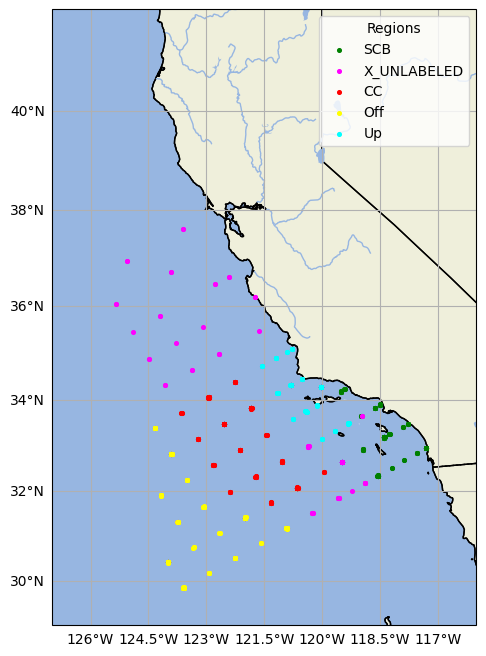

In [22]:
fig = plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-127, -116, 29, 42], crs=ccrs.PlateCarree())

for code in code_filled.unique():
    code_df = meta[meta['Code_Filled'] == code]
    ax.scatter(x=code_df['Lon_Dec'], y=code_df['Lat_Dec'], color=color_map[code], label=code, s=7, transform=ccrs.PlateCarree(), zorder=3)
ax.legend(title='Regions')
plt.show()

---

We'll leave the northern points unlabeled since there are fewer samples there, but we will interpolate the southern points by assigning it to the nearest station

---

In [23]:
from scipy.spatial import distance

region_lookup = meta[~meta['Code_CCE'].isna()][['Lon_Dec', 'Lat_Dec', 'Code_CCE']].drop_duplicates()
region_lookup = region_lookup.replace({'SCO': 'SCB'})
def fill_code(row):
    code = region_lookup[(region_lookup['Lon_Dec'] == row['Lon_Dec']) & (region_lookup['Lat_Dec'] == row['Lat_Dec'])]
    if len(code) > 0:
        return code['Code_CCE'].iloc[0]
    else:
        current_point = (row['Lat_Dec'], row['Lon_Dec'])
        distances = region_lookup[['Lat_Dec', 'Lon_Dec']].apply(
            lambda x: distance.euclidean((x['Lat_Dec'], x['Lon_Dec']), current_point), axis=1
        ).values
        closest_point = np.argmin(distances)
        if distances[closest_point] < 0.05: # if there is a labeled point at the same station
            return region_lookup.iloc[closest_point]['Code_CCE']
        elif row['Lat_Dec'] > 34: # create new region for the northern unlabeled points
            return 'X_NU'
        else: # otherwise assign nearest station
            return region_lookup.iloc[closest_point]['Code_CCE']
meta['Code_CCE'] = meta.apply(fill_code, axis=1)

In [24]:
color_vals = sorted(meta['Code_CCE'].unique())
map_colors = ['red', 'yellow', 'green', 'cyan', 'magenta']
color_map = {color_vals[i]: map_colors[i] for i in range(len(color_vals))}
meta['color'] = meta['Code_CCE'].replace(color_map)

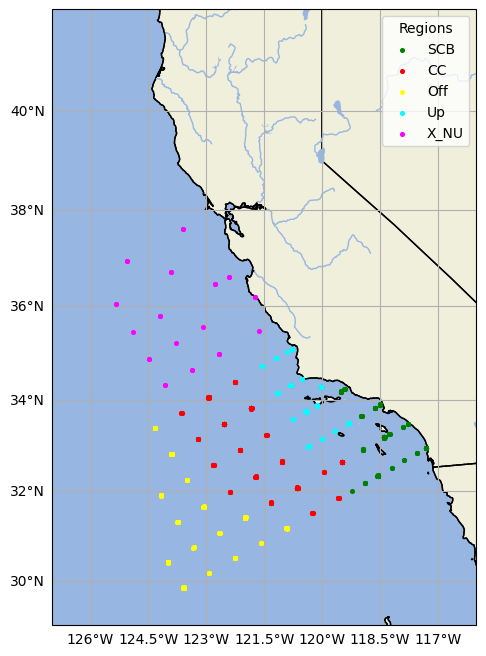

In [25]:
fig = plt.figure(figsize=(6, 8))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_extent([-127, -116, 29, 42], crs=ccrs.PlateCarree())
for code in meta['Code_CCE'].unique():
    code_df = meta[meta['Code_CCE'] == code]
    ax.scatter(x=code_df['Lon_Dec'], y=code_df['Lat_Dec'], color=color_map[code], label=code, s=7, transform=ccrs.PlateCarree(), zorder=3)
ax.legend(title='Regions')
plt.show()

In [26]:
meta.columns

Index(['sample_num', 'Cruise', 'Event', 'Order_Occ', 'Sta_ID', 'Cast_Type',
       'Cardinal_Sta', 'Station_Notes', 'Bottle', 'Assoc_Bottle', 'Depthm',
       'Bottle_Notes', 'NCOG_DNA', 'NCOG_RNA', 'DNA_VolFilt', 'RNA_VolFilt',
       'Pump_Speed', 'DNA_RNA_Vol_Notes', 'Filt_Str', 'Filt_End',
       'Filt_Str_Notes', 'Filt_End_Notes', 'Gly.Sample', 'Sterivex_Notes',
       'std_18S', 'Date', 'Time', 'DateTime', 'Lat_Dec', 'Lon_Dec', 'Distance',
       'NoCCSamples', 'Del_Depth', 'CC_Depth', 'T_degC', 'Salnty', 'STheta',
       'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug', 'ChlorA', 'Phaeop',
       'RecInd', 'Code_CCE', 'IntChl', 'IntC14', 'NCDepth', 'MLD_Sigma',
       'season', 'year', 'sample_type', 'sample_type2', 'siex', 'exclude',
       'Code_Filled', 'color'],
      dtype='object')

In [27]:
meta_env_vars = meta[['Code_CCE', 'Depthm', 'Lat_Dec', 'Lon_Dec', 'Del_Depth', 'CC_Depth', 'T_degC', 'Salnty', 'STheta',
                      'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug', 'ChlorA', 'Phaeop', 'NCDepth', 'MLD_Sigma']]

In [28]:
meta['Code_CCE'].value_counts()

Code_CCE
CC      294
Off     250
SCB     173
Up      149
X_NU     29
Name: count, dtype: int64

## Run FlashWeave on each region

In [29]:
for region_id in sorted(meta['Code_CCE'].unique()):
    print('Runninng', region_id)
    region_dir = f'data/regions/{region_id}'
    sixteenS_file = '{}/NCOG_16S_{}.tsv'.format(region_dir, region_id)
    eighteenS_file = '{}/NCOG_18S_v4_{}.tsv'.format(region_dir, region_id)
    meta_file = '{}/NCOG_meta_{}.tsv'.format(region_dir, region_id)
    outfile = '{}/NCOG_graph_{}.gml'.format(region_dir, region_id)
    print('-'*50)
    print(['julia', f'src/run_flashweave_local_network.jl', sixteenS_file, eighteenS_file, meta_file, outfile])
    # Create subprocess for flashweave using sixteenS, eighteenS, and meta file (use P_WAIT to wait for execution)
    result = sp.run(['julia', f'src/run_flashweave_local_network.jl', sixteenS_file, eighteenS_file, meta_file, outfile], cwd='..')
    print('-'*50)

Runninng CC
--------------------------------------------------
['julia', 'src/run_flashweave_local_network.jl', 'data/regions/CC/NCOG_16S_CC.tsv', 'data/regions/CC/NCOG_18S_v4_CC.tsv', 'data/regions/CC/NCOG_meta_CC.tsv', 'data/regions/CC/NCOG_graph_CC.gml']

### Loading data ###

### Normalizing ###

Normalization
	-> multiple data sets provided, using separate normalization mode

### Learning interactions ###

Inferring network with FlashWeave - sensitive (conditional)

	Run information:
	sensitive - true
	heterogeneous - false
	max_k - 3
	alpha - 0.01
	sparse - false
	workers - 1
	OTUs - 3774
	MVs - 0

Automatically setting 'n_obs_min' to 20 for enhanced reliability
Computing univariate associations

Univariate degree stats:
Summary Stats:
Length:         3774
Missing Count:  0
Mean:           362.529942
Minimum:        8.000000
1st Quartile:   141.000000
Median:         293.000000
3rd Quartile:   502.000000
Maximum:        1499.000000



Starting conditioning search

Preparing worke

┌ Warning: adaptive pseudo-counts for 1 samples were lower than machine precision due to insufficient counts, removing them
└ @ FlashWeave ~/.julia/packages/FlashWeave/j91Ng/src/preprocessing.jl:125
┌ Warning: adaptive pseudo-counts for 2 samples were lower than machine precision due to insufficient counts, removing them
└ @ FlashWeave ~/.julia/packages/FlashWeave/j91Ng/src/preprocessing.jl:125
┌ Warning: 2 samples had only zero counts in at least one data set and will not be used for inference
└ @ FlashWeave ~/.julia/packages/FlashWeave/j91Ng/src/preprocessing.jl:562



### Learning interactions ###

Inferring network with FlashWeave - sensitive (conditional)

	Run information:
	sensitive - true
	heterogeneous - false
	max_k - 3
	alpha - 0.01
	sparse - false
	workers - 1
	OTUs - 3526
	MVs - 0

Automatically setting 'n_obs_min' to 20 for enhanced reliability
Computing univariate associations

Univariate degree stats:
Summary Stats:
Length:         3526
Missing Count:  0
Mean:           458.321044
Minimum:        8.000000
1st Quartile:   117.000000
Median:         302.000000
3rd Quartile:   688.000000
Maximum:        1683.000000



Starting conditioning search

Preparing workers..

Done. Starting inference..
Starting convergence checks at 14250 edges.
Latest convergence step change: 0.36627
Latest convergence step change: 0.38702

Postprocessing
Complete

Finished inference. Total time taken: 28.399s
--------------------------------------------------
Runninng SCB
--------------------------------------------------
['julia', 'src/run_flashweave_local_net

┌ Warning: adaptive pseudo-counts for 1 samples were lower than machine precision due to insufficient counts, removing them
└ @ FlashWeave ~/.julia/packages/FlashWeave/j91Ng/src/preprocessing.jl:125
┌ Warning: 1 samples had only zero counts in at least one data set and will not be used for inference
└ @ FlashWeave ~/.julia/packages/FlashWeave/j91Ng/src/preprocessing.jl:562



### Learning interactions ###

Inferring network with FlashWeave - sensitive (conditional)

	Run information:
	sensitive - true
	heterogeneous - false
	max_k - 3
	alpha - 0.01
	sparse - false
	workers - 1
	OTUs - 3473
	MVs - 0

Automatically setting 'n_obs_min' to 20 for enhanced reliability
Computing univariate associations

Univariate degree stats:
Summary Stats:
Length:         3473
Missing Count:  0
Mean:           183.045782
Minimum:        3.000000
1st Quartile:   70.000000
Median:         144.000000
3rd Quartile:   263.000000
Maximum:        843.000000



Starting conditioning search

Preparing workers..

Done. Starting inference..
Starting convergence checks at 9834 edges.
Latest convergence step change: 0.38076
Latest convergence step change: 0.33482
Latest convergence step change: 0.24337

Postprocessing
Complete

Finished inference. Total time taken: 13.537s
--------------------------------------------------
Runninng X_NU
--------------------------------------------------
[

## Regional Network Analysis

In [32]:
def calculate_graph_metrics(region_nw_gph):
    # Convert networkx graph to igraph
    G_ig = ig.Graph.from_networkx(region_nw_gph)
    node_count = G_ig.vcount()
    edge_count = G_ig.ecount()
    
    # Calculate number of positive and negative edges
    pos_edges = len([e for e in G_ig.es if e['weight'] > 0])
    neg_edges = len([e for e in G_ig.es if e['weight'] < 0])

    # Mean degree
    mean_degree = np.mean(G_ig.degree())

    # Mean strength
    # Calculate the strength of each node
    node_strengths = G_ig.strength(weights=G_ig.es['weight'])
    # Calculate the average strength of the nodes
    mean_node_strength = sum(node_strengths) / len(node_strengths)
    
    # Mean weight
    mean_weight = np.sum(G_ig.es['weight']) / G_ig.ecount()

    # Edge density
    edge_density = (2 * G_ig.ecount()) / (G_ig.vcount() * (G_ig.vcount() - 1))

    # Calculate the graph's clustering coefficient
    clustering_coefficient = G_ig.transitivity_undirected()
    
    # Calculate the average shortest path length
    average_shortest_path_length = G_ig.average_path_length(directed=False)
    
    # Calculate the diameter
    diameter = G_ig.diameter(directed=False)
    
    # Calculate the average betweenness
    betweenness = G_ig.betweenness(directed=False)
    average_betweenness = np.mean(betweenness)
    
    # Extract positive network (only positive weights)
    positive_edges = [(e.source, e.target) for e in G_ig.es if e['weight'] > 0]
    positive_weights = [e['weight'] for e in G_ig.es if e['weight'] > 0]
    G_ig_positive = ig.Graph(edges=positive_edges)
    G_ig_positive.es['weight'] = positive_weights
    
    # Calculate the modularity of the positive network
    positive_clusters = G_ig_positive.community_fastgreedy(weights='weight').as_clustering()
    modularity_positive = positive_clusters.modularity
    
    # Number of modules in the positive network
    number_of_modules_positive = len(positive_clusters)

    return {
        'Nodes': node_count,
        'Edges': edge_count,
        'Positive Edges (%)': str(pos_edges) + ' (' + str(np.round(100 * pos_edges/(pos_edges + neg_edges), 2)) + '%)',
        'Negative Edges': neg_edges,
        'Mean degree': mean_degree,
        'Mean strength': mean_node_strength,
        'Mean weight': mean_weight,
        'Edge density': edge_density,
        'Average clustering coefficient (transitivity)': clustering_coefficient,
        'Average shortest path length': average_shortest_path_length,
        'Diameter': diameter,
        'Average betweenness': average_betweenness,
        'Modularity of positive network': modularity_positive, # these two are more difficult in networkx than igraph
        'Number of modules in positive network': number_of_modules_positive 
    }

In [33]:
region_nw_data = []
region_ids = sorted(meta['Code_CCE'].unique())
for region in region_ids:
    region_meta = pd.read_csv(
        '../data/regions/{}/NCOG_meta_{}.tsv'.format(region, region),
        sep='\t',
        index_col=0
    )
    metavars_median = region_meta[['Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug',
                                'ChlorA', 'NCDepth']].median().rename(lambda x: x + '_median')
    region_nw = nx.read_gml('../data/regions/{}/NCOG_graph_{}.gml'.format(region, region))
    region_nw_stats = calculate_graph_metrics(region_nw)
    region_nw_data.append(pd.concat([pd.Series(region_nw_stats), metavars_median]))
region_nw_data = pd.DataFrame(region_nw_data, index=region_ids)


In [34]:
region_nw_data

,Nodes,Edges,Positive Edges (%),Negative Edges,Mean degree,Mean strength,Mean weight,Edge density,Average clustering coefficient (transitivity),Average shortest path length,Diameter,Average betweenness,Modularity of positive network,Number of modules in positive network,Depthm_median,T_degC_median,Salnty_median,O2ml_L_median,PO4ug_median,SiO3ug_median,NO3ug_median,NH3ug_median,ChlorA_median,NCDepth_median
CC,3774,18686,17586 (94.11%),1100,9.902491,1.875458,0.189393,0.002625,0.017945,4.108762,11,5864.678590,0.538917,12,14.0,15.0510,33.342051,5.8030,0.31,1.79,0.00,0.015,0.385,52.018696
Off,3526,15611,14769 (94.61%),842,8.854793,1.798859,0.203151,0.002512,0.015029,4.215859,9,5667.952070,0.517772,12,18.5,15.7735,33.354849,5.6575,0.28,1.93,0.00,0.000,0.202,95.134085
SCB,3652,12911,12387 (95.94%),524,7.070646,1.880081,0.265900,0.001937,0.011706,4.667688,12,6618.785323,0.562596,18,13.0,15.5060,33.505100,5.7110,0.33,2.24,0.07,0.050,0.643,32.118451
Up,3473,10828,10254 (94.7%),574,6.235531,1.847566,0.296297,0.001796,0.015325,5.036302,11,6970.757558,0.588751,27,10.0,14.2790,33.509899,5.7640,0.34,2.80,0.74,0.070,1.448,21.329966
X_NU,2541,3770,3353 (88.94%),417,2.967336,1.625525,0.547806,0.001168,0.026468,9.055246,28,9879.081858,0.837580,116,10.0,13.0600,33.040401,6.0400,0.34,2.06,0.34,0.000,0.590,43.751196


In [ ]:
diatom_degree_by_genus = []
region_ids = sorted(meta['Code_CCE'].unique())
region_ids = ['Up']
for region in region_ids:
    region_meta = pd.read_csv(
        'flashweave_region_networks/{}/NCOG_meta_{}.tsv'.format(region, region.replace(' ', '_')),
        sep='\t',
        index_col=0
    )
    region_sixteenS = pd.read_csv(
        'flashweave_region_networks/{}/NCOG_16S_{}.tsv'.format(region, region.replace(' ', '_')),
        sep='\t',
        index_col=0
    ).T
    region_sixteenS = region_sixteenS.merge(taxon_map[['otu_id', 'Taxonomy']], left_index=True, right_on='otu_id')
    region_eighteenS = pd.read_csv(
        'flashweave_region_networks/{}/NCOG_18S_v4_{}.tsv'.format(region, region.replace(' ', '_')),
        sep='\t',
        index_col=0
    ).T
#     metavars_avg = region_meta[['Depthm', 'T_degC', 'Salnty', 'O2ml_L', 'PO4ug', 'SiO3ug', 'NO3ug', 'NH3ug',
#                                 'ChlorA', 'NCDepth']].median().rename(lambda x: x + '_median')
#     region_nw = nx.read_gml('flashweave_region_networks/graphs/NCOG_graph_{}.gml'.format(region.replace(' ', '_')))
    
#     region_nw_data.append(pd.concat([pd.Series(region_nw_stats), metavars_avg]))
# region_nw_data = pd.DataFrame(region_nw_data, index=region_ids)


In [ ]:
region_sixteenS